In [92]:
from importlib import reload
import galsurvey
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt

reload(galsurvey)

<module 'galsurvey' from 'C:\\Users\\yanlo\\OneDrive - California Institute of Technology\\2019-Bispectrum-Neutrino\\Notebooks\\galsurvey.py'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
#matplotlib.rcParams['font.serif'] = "Times New Roman"
#matplotlib.rcParams.update({'font.size': 10})

In [3]:
omega_m = 0.307494
omega_bh2 = 0.022300
omega_ch2 = 0.118800
omega_l = 1 - omega_m
h = np.sqrt((omega_bh2 + omega_ch2) / omega_m)
omega_b = omega_bh2/h**2
sf = 99.91 #from camb

In [4]:
cosmo_params = {
    'Omega_m': omega_m,
    'Omega_L': omega_l,
    'Omega_b': omega_b,
    'h': h,
    's_f': sf,
    'sigma8_0': 0.9
}

In [5]:
cosmo = galsurvey.cosmology(cosmo_params)

In [6]:
attrs = vars(cosmo)
print(', '.join("%s: %s" % item for item in attrs.items()))

Omega_m: 0.307494, Omega_L: 0.6925060000000001, Omega_b: 0.04859756343019135, h: 0.6773999868566161, s_f: 99.91, sigma8_0: 0.9, astropy_cosmology: FlatLambdaCDM(H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None), D0: 0.7825237557360316


In [7]:
cosmo.comoving_distance(1)

2302.4862192049272

In [8]:
cosmo.linear_growth_factor(0)

0.7825237557360316

In [9]:
ps_file='planck_camb_56106182_matterpower_z0.dat'
ps_nw_file='planck_camb_56106182_matterpower_smooth_z0.dat'
ps = galsurvey.ps_interpolation(ps_file, ps_nw_file)

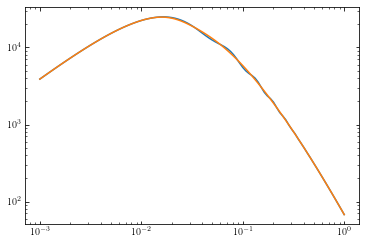

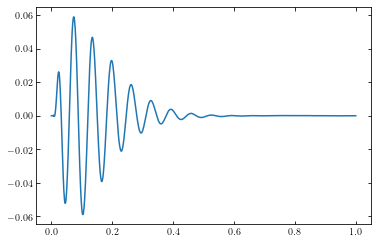

In [10]:
k=np.logspace(-3, 0, num=100)
p=ps.matter_power_spectrum(k)
pnw=ps.matter_power_spectrum_no_wiggle(k)
plt.loglog(k, p)
plt.loglog(k, pnw)
plt.show()

k=np.linspace(0.001, 1, num=1000)
o=ps.oscillation_part(k)
plt.plot(k, o)
plt.show()

In [11]:
survey_geo = {
    'f_sky': 0.5,
    'N_g': 1e7,
    'z_min': 0.1,
    'z_max': 1.95,
    'dz': 0.1
}
survey_params = {
    'Sigma_0': 16.6,
    'reconstruction_rate': 0.5,
    'b_0': 0.95,
    'survey_type': 'spectroscopic'
}

ig_full = ['RSD', 'damping', 'FOG', 'galactic_bias', 'reconstruction']
ig_none = []
ingredients = ig_full


sf_p18 = 97.288
dsf_p18 = 0.799344

priors = {
    'alpha_prior': {
        'mean': sf_p18/sf,
        'stdev': dsf_p18/sf
    },
    'beta_prior': {
        'mean': 1.0,
        'stdev': 1e100 # to be constrained
    }
}

priors_plk = {
    'alpha_prior': {
        'mean': sf_p18/sf,
        'stdev': dsf_p18/sf
    },
    'beta_prior': {
        'mean': 1.0,
        'stdev': 1e100 # to be constrained
    }
}

In [12]:
svy = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ingredients, priors)
svy.cosmo = cosmo
svy.ps = ps
#svy.get_ready()

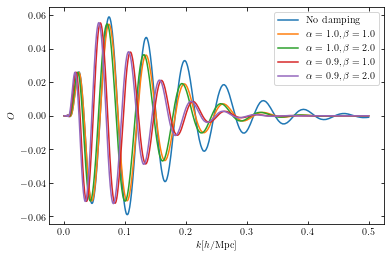

In [13]:
import itertools
k=np.linspace(0.001, 0.5, num=1000)
svy.alpha_prior['mean'] = 1
svy.beta_prior['mean'] = 1
o=svy.oscillation_part(k, damp=False)

plt.figure(figsize=(6,4))
plt.plot(k, o, label='No damping')

for [a, b] in list(itertools.product([1, 0.9], [1, 2])):
    svy.alpha_prior['mean'] = a
    svy.beta_prior['mean'] = b
    o=svy.oscillation_part(k)
    plt.plot(k, o, label=r'$\alpha=%.1f, \beta=%.1f$'%(a, b))
plt.legend()
plt.xlabel(r'$k[h/{\rm Mpc}]$')
plt.ylabel(r'$O$')
plt.savefig('oscillations.pdf', bbox_inches='tight')
plt.show()



svy.alpha_prior['mean'] = 1.0
svy.beta_prior['mean'] = 1.0

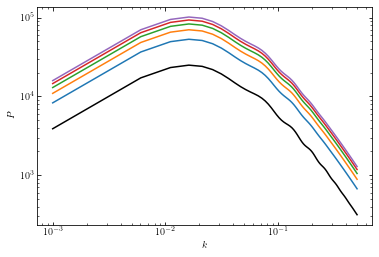

In [14]:
klst = np.linspace(0.001, 0.5, num=100) 
zlst = [0, 0.5, 1, 1.5, 2]
plt.loglog(klst, ps.matter_power_spectrum(klst), 'k')
for z in zlst:
    plst = svy.power_spectrum(klst, 1, z)
    plt.loglog(klst, plst)
plt.xlabel(r'$k$')
plt.ylabel(r'$P$')
plt.show()

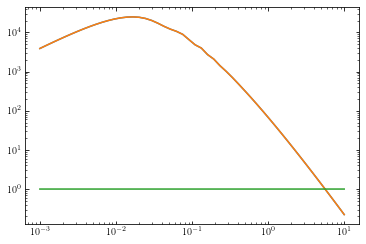

In [93]:
svy_m = galsurvey.survey(cosmo, ps, survey_geo, survey_params, [], priors)
k = np.logspace(-3, 1)
p = ps.matter_power_spectrum(k)
p_m = svy_m.power_spectrum(k)
plt.loglog(k, p)
plt.loglog(k, p_m)
plt.loglog(k, p_m/p)
plt.show()

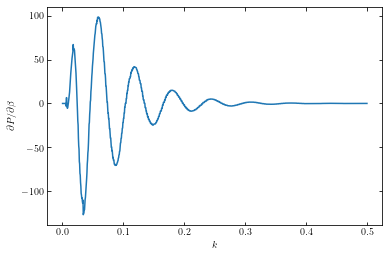

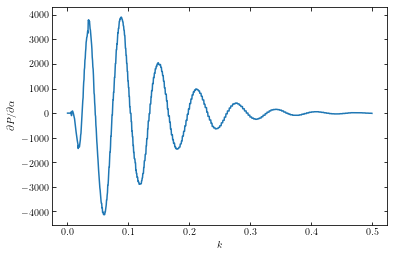

In [16]:
klst = np.linspace(0.001, 0.5, num=1000) 
vlst = svy_m.power_spectrum_derivative(klst)
plt.plot(klst, vlst[1])
plt.xlabel(r'$k$')
plt.ylabel(r'$\partial P/ \partial \beta$')
plt.show()

plt.plot(klst, vlst[0])
plt.xlabel(r'$k$')
plt.ylabel(r'$\partial P/ \partial \alpha$')
plt.show()

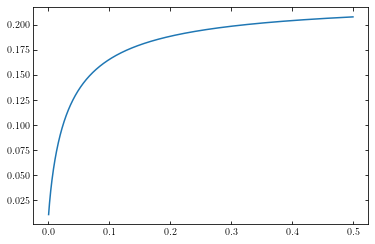

In [17]:
plt.plot(klst, galsurvey.f_phase(klst))
plt.show()

In [71]:
region_ps_0={
    'k_min': 0.01,
    'k_max': 1.0,
    'mu_min': -1.0,
    'mu_max': 1.0
}
regions_ps = [region_ps_0]

#svy.fisher_matrix_ps(regions_ps)

In [19]:
%timeit svy.fisher_matrix_ps(regions_ps, div_k=100, div_mu=10, parallel=False)

37.6 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
def get_integrand_mat(svy, k, l):
    tiny = 1e-4
    deltalst = y = np.linspace(tiny*svy.pisf, (4-tiny)*svy.pisf, num=20)
    thetalst = x = np.linspace(np.pi*tiny, np.pi*(1-tiny), num=20)
    dmat, tmat = np.meshgrid(deltalst, thetalst)
    #4extent = np.min(x), np.max(x), np.min(y), np.max(y)
    Amat = np.zeros(dmat.shape)
    print(svy.alpha_prior, svy.beta_prior)
    for i in range(len(deltalst)):
        for j in range(len(thetalst)):
            Amat[i,j] = svy.integrand_delta_theta(dmat[i,j], tmat[i,j])[k,l]
    return Amat

{'mean': 1.0, 'stdev': 0.008000640576518867} {'mean': 1.0, 'stdev': 1e+100}


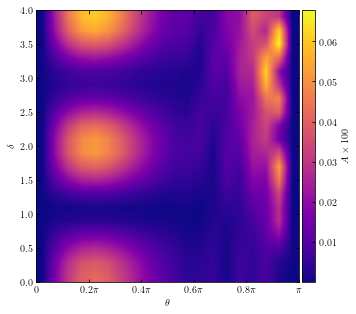

In [101]:
#svy_m.integrand_delta_theta(0.1, 0.8)
Amat = get_integrand_mat(svy_m, 1,1)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter, MultipleLocator
f = plt.figure(figsize=(5, 5))
ax = f.add_subplot(111)
cmap = plt.get_cmap('plasma')
extent = 0, np.pi, 0, 4
im = ax.imshow(Amat.T*100, cmap=cmap, interpolation='bilinear', extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label(r'$A\times 100$')

ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val, pos: r'\rm 0' if val==0 else r'\rm {:.3g}$\pi$'.format(val/np.pi) if np.abs(val)!=np.pi else r'$-\pi$' if val==-np.pi else r'$\pi$'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/5))

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\delta$')
plt.savefig('integrand_tf.pdf', bbox_inches='tight')
plt.show()

{'mean': 1.0, 'stdev': 0.008000640576518867} {'mean': 1.0, 'stdev': 1e+100}
{'mean': 1.0, 'stdev': 0.008000640576518867} {'mean': 1.0, 'stdev': 1e+100}
{'mean': 1.0, 'stdev': 0.008000640576518867} {'mean': 1.0, 'stdev': 1e+100}


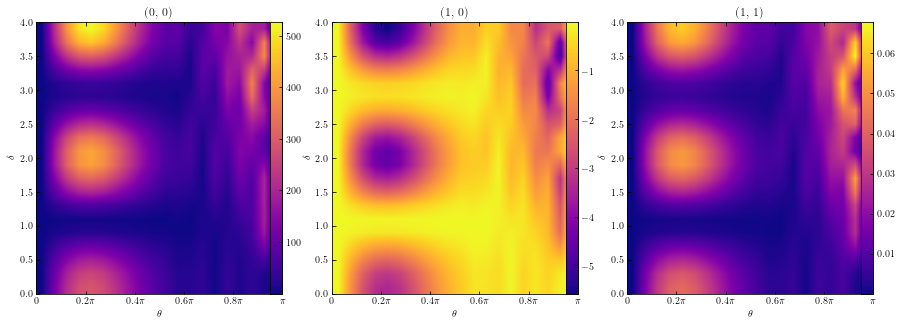

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(2):
    for j in range(2):
        if i<j: 
            continue
        else:
            Amat = get_integrand_mat(svy_m, i,j)
            ax = axs[i+ j]
            cmap = plt.get_cmap('plasma')
            extent = 0, np.pi, 0, 4
            im = ax.imshow(Amat.T*100, cmap=cmap, interpolation='bilinear', 
                           extent=extent, origin='lower', aspect='auto')
            ax.xaxis.set_major_formatter(FuncFormatter(
                lambda val, pos: r'\rm 0' if val==0 else r'\rm {:.3g}$\pi$'.format(val/np.pi) 
                if np.abs(val)!=np.pi else r'$-\pi$' if val==-np.pi else r'$\pi$'))
            ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/5))
            ax.title.set_text('(%d, %d)'%(i, j))
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad='-5%')
            cb = plt.colorbar(im, cax=cax)
            ax.set_xlabel(r'$\theta$')
            ax.set_ylabel(r'$\delta$')

plt.show()

In [21]:
region_bs_0={
    'k1_min': 0.01,
    'k1_max': 0.5,
    'k2_min': 0.01,
    'k2_max': 0.5,
    'k3_min': 0.01,
    'k3_max': 0.5,
}
regions_bs = [region_bs_0]

In [65]:
svy_m.fisher_matrix_bs(regions_bs, div_k1=20, div_k2=20, div_k3=20)

0.15000000000000002 [[ 5.97190184e+07 -6.81049198e+05]
 [-6.81049198e+05  8.50717902e+03]]
0.25 [[ 1.91695656e+08 -2.18614064e+06]
 [-2.18614064e+06  2.73077038e+04]]
0.35000000000000003 [[ 3.99702088e+08 -4.55829306e+06]
 [-4.55829306e+06  5.69389336e+04]]
0.45000000000000007 [[ 6.76579033e+08 -7.71586038e+06]
 [-7.71586038e+06  9.63810041e+04]]
0.55 [[ 1.00998617e+09 -1.15181108e+07]
 [-1.15181108e+07  1.43875994e+05]]
0.65 [[ 1.38606805e+09 -1.58070337e+07]
 [-1.58070337e+07  1.97450149e+05]]
0.7500000000000001 [[ 1.79155249e+09 -2.04312700e+07]
 [-2.04312700e+07  2.55212798e+05]]
0.8500000000000001 [[ 2.21478526e+09 -2.52579122e+07]
 [-2.52579122e+07  3.15503757e+05]]
0.9500000000000001 [[ 2.64610404e+09 -3.01767692e+07]
 [-3.01767692e+07  3.76946598e+05]]
1.05 [[ 3.07783765e+09 -3.51003570e+07]
 [-3.51003570e+07  4.38448531e+05]]
1.15 [[ 3.50411710e+09 -3.99617442e+07]
 [-3.99617442e+07  4.99173500e+05]]
1.25 [[ 3.92061151e+09 -4.47115408e+07]
 [-4.47115408e+07  5.58504558e+05]]
1

array([[ 5.85794520e+10, -6.68053147e+08],
       [-6.68053147e+08,  8.34484165e+06]])

In [23]:
0.5/(np.pi/svy.cosmo.s_f)

15.901170364311264

In [24]:
print(svy_m.alpha_stdev_bs)
print(svy_m.beta_stdev_bs)

1.400567227470198e-05
0.00117345803260342


In [72]:
for zmax in [1.0, 1.05, 1.1]:
    survey_geo['z_max']=zmax
    survey_geo['N_g']=1e7
    svy = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ingredients, priors)
    fisher = svy.fisher_matrix_ps(regions_ps, div_k=div_k, div_mu=div_mu)
    print(fisher)
    print(svy.zmid_list)
    print(svy.z_max_int)
    print(svy.beta_stdev)

[[ 1.12206629e+05 -1.20820189e+03]
 [-1.20820189e+03  1.72828629e+01]]
[0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
1.0
0.48374330012693584
[[ 1.14000177e+05 -1.24477608e+03]
 [-1.24477608e+03  1.80244108e+01]]
[0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.025]
1.0
0.47497433931874317
[[ 1.15386969e+05 -1.27639347e+03]
 [-1.27639347e+03  1.87000638e+01]]
[0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05]
1.1
0.4672290589615916


In [73]:
zlst = np.linspace(0.2, 4, num=100)
Nglst = [ 1e6, 1e7, 1e8, 1e100]
slst = np.zeros((len(Nglst), len(zlst)))
div_k, div_mu = 20, 10
#fisherlst = np.zeros((len(Nglst), len(zlst), 2, 2))
for j in range(len(zlst)):
    z = zlst[j]
    print('%.2f'%(z), end=' ')
    survey_geo['z_max']=z
    for i in range(len(Nglst)):
        survey_geo['N_g']=Nglst[i]
        svy = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ingredients, priors)
        #svy.cosmo = cosmo
        #svy.ps = ps
        #svy.get_ready()
        fisher = svy.fisher_matrix_ps(regions_ps, div_k=div_k, div_mu=div_mu)
        slst[i,j] = svy.beta_stdev
        del svy

0.20 0.24 0.28 0.32 0.35 0.39 0.43 0.47 0.51 0.55 0.58 0.62 0.66 0.70 0.74 0.78 0.81 0.85 0.89 0.93 0.97 1.01 1.04 1.08 1.12 1.16 1.20 1.24 1.27 1.31 1.35 1.39 1.43 1.47 1.51 1.54 1.58 1.62 1.66 1.70 1.74 1.77 1.81 1.85 1.89 1.93 1.97 2.00 2.04 2.08 2.12 2.16 2.20 2.23 2.27 2.31 2.35 2.39 2.43 2.46 2.50 2.54 2.58 2.62 2.66 2.69 2.73 2.77 2.81 2.85 2.89 2.93 2.96 3.00 3.04 3.08 3.12 3.16 3.19 3.23 3.27 3.31 3.35 3.39 3.42 3.46 3.50 3.54 3.58 3.62 3.65 3.69 3.73 3.77 3.81 3.85 3.88 3.92 3.96 4.00 

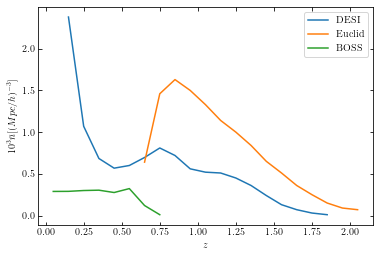

In [74]:
ndesi = np.loadtxt('desi-density.txt')
neuclid = np.loadtxt('euclid-density.txt')
nboss = np.loadtxt('boss-density.txt')
ndesi[:,1]/=1e3
neuclid[:,1]/=1e3
nboss[:,1]/=1e3
plt.plot(ndesi[:,0], ndesi[:,1]*1e3, label = r'\rm DESI')
plt.plot(neuclid[:,0], neuclid[:,1]*1e3, label = r'\rm Euclid')
plt.plot(nboss[:,0], nboss[:,1]*1e3, label = r'\rm BOSS')
plt.xlabel(r'$z$')
plt.ylabel(r'$10^3\bar{n}[(Mpc/h)^{-3}]$')
plt.legend()
plt.show()

In [75]:
sky_deg = 4*np.pi*(180/np.pi)**2
desi_geo = {
    'f_sky': 14000/sky_deg,
    'ng_z_list': ndesi,
    'dz': 0.1
}
euclid_geo = {
    'f_sky': 15000/sky_deg,
    'ng_z_list': neuclid,
    'dz': 0.1
}
boss_geo = {
    'f_sky': 10000/sky_deg,
    'ng_z_list': nboss,
    'dz': 0.1
}
desi = galsurvey.survey(cosmo, ps, desi_geo, survey_params, ingredients, priors_plk)
#desi.cosmo = cosmo
#desi.ps = ps
#desi.get_ready()
fisher_desi = desi.fisher_matrix_ps(regions_ps, div_k=div_k, div_mu=div_mu)

euclid = galsurvey.survey(cosmo, ps, euclid_geo, survey_params, ingredients, priors)
#euclid.cosmo = cosmo
#euclid.ps = ps
#euclid.get_ready()
fisher_euclid = euclid.fisher_matrix_ps(regions_ps, div_k=div_k, div_mu=div_mu)

boss = galsurvey.survey(cosmo, ps, boss_geo, survey_params, ingredients, priors)
#boss.cosmo = cosmo
#boss.ps = ps
#boss.get_ready()
fisher_boss = boss.fisher_matrix_ps(regions_ps, div_k=div_k, div_mu=div_mu)

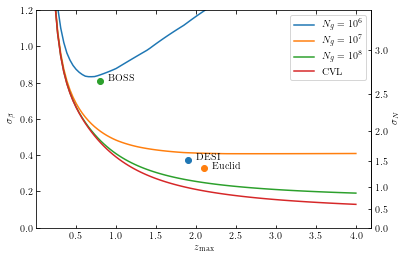

In [76]:
from scipy.interpolate import make_interp_spline, BSpline



def b2n(x):
    return 4.4/1.45 - 4.4* (-x + 1)/(2.45 - (-x + 1))
def n2b(y):
    t = 4.4/1.45 -y
    return 1 - 2.45*t/(t+4.4)
    
matplotlib.rcParams['ytick.right'] = False
fig, ax = plt.subplots()
ax_r = ax.secondary_yaxis("right", functions=(b2n, n2b))

labels = [ r'$N_g=10^6$', r'$N_g=10^7$', r'$N_g=10^8$', r'\rm CVL']
for i in range(len(slst)):
    #xnew = np.linspace(zlst.min(), zlst.max(), 300) 
    #spl = make_interp_spline(zlst, slst[i], k=3)
    #ynew = spl(xnew)
    #ax.plot(xnew, ynew, label=labels[i])
    ax.plot(zlst, slst[i],label=labels[i])

ax.scatter(desi.z_max, desi.beta_stdev)
ax.text(desi.z_max+0.1, desi.beta_stdev, r'\rm DESI')
ax.scatter(euclid.z_max, euclid.beta_stdev)
ax.text(euclid.z_max+0.1, euclid.beta_stdev, r'\rm Euclid')
ax.scatter(boss.z_max, boss.beta_stdev)
ax.text(boss.z_max+0.1, boss.beta_stdev, r'\rm BOSS')
ax.legend()
ax.set_xlabel(r'$z_{\rm max}$')
ax.set_ylabel(r'$\sigma_\beta$')
ax_r.set_ylabel(r'$\sigma_N$')
ax.set_ylim(0,1.2)
plt.savefig('sigmabeta.pdf', bbox_inches='tight')
plt.show()

matplotlib.rcParams['ytick.right'] = True

In [116]:
%timeit desi.integrand_ps(0.4, 0.4, 0.4, 1, 1, simplify=False)
%timeit desi.integrand_ps(0.4, 0.4, 0.4, 1, 1, simplify=True)
print(desi.integrand_ps(0.2, 0.4, 0.4, 0, 0, simplify=False))
print(desi.integrand_ps(0.2, 0.4, 0.4, 0, 0, simplify=True))

347 ns ± 4.14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
346 ns ± 3.48 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
0.0010032495134611843
0.0009948736519798569


In [117]:
%timeit desi.naive_integration_ps(args=(0.4, 1, 1))

58.1 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


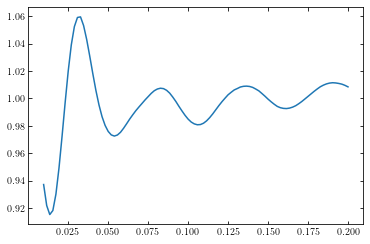

In [196]:
klst = np.linspace(0.01, 0.2, num=100)
rlst = desi.R_bi(kargs=(klst, desi.pisf, 0))
plt.plot(klst, rlst)

In [268]:
svy = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ingredients, priors)
svy.alpha_prior['mean'] = 1.0
svy.beta_prior['mean'] = 1.0
def get_Amat(svy):
    tiny = 1e-4
    deltalst = y = np.linspace(tiny*svy.pisf, (4-tiny)*svy.pisf, num=20)
    thetalst = x = np.linspace(np.pi*tiny, np.pi*(1-tiny), num=20)
    dmat, tmat = np.meshgrid(deltalst, thetalst)
    #4extent = np.min(x), np.max(x), np.min(y), np.max(y)
    Amat = np.zeros(dmat.shape)
    print(svy.alpha_prior, svy.beta_prior)
    for i in range(len(deltalst)):
        for j in range(len(thetalst)):
            Amat[i,j] = svy.A_bi(dmat[i,j], tmat[i,j], k1_min=0.01, div_k1=10000)
    return Amat

Amat = get_Amat(svy)

{'mean': 1.0, 'stdev': 0.008000640576518867} {'mean': 1.0, 'stdev': 1e+100}


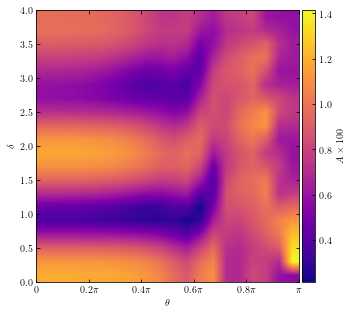

In [257]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter, MultipleLocator
f = plt.figure(figsize=(5, 5))
ax = f.add_subplot(111)
cmap = plt.get_cmap('plasma')
extent = 0, np.pi, 0, 4
im = ax.imshow(Amat.T*100*(0.2-0.01), cmap=cmap, interpolation='bilinear', extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label(r'$A\times 100$')

ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val, pos: r'\rm 0' if val==0 else r'\rm {:.3g}$\pi$'.format(val/np.pi) if np.abs(val)!=np.pi else r'$-\pi$' if val==-np.pi else r'$\pi$'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/5))

ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\delta$')
plt.savefig('bi_inter.pdf', bbox_inches='tight')
plt.show()

{'mean': 1.0, 'stdev': 0.008000640576518867} {'mean': 1.0, 'stdev': 1e+100}
{'mean': 1.0, 'stdev': 0.008000640576518867} {'mean': 2.0, 'stdev': 1e+100}
{'mean': 0.9, 'stdev': 0.008000640576518867} {'mean': 1.0, 'stdev': 1e+100}
{'mean': 0.9, 'stdev': 0.008000640576518867} {'mean': 2.0, 'stdev': 1e+100}


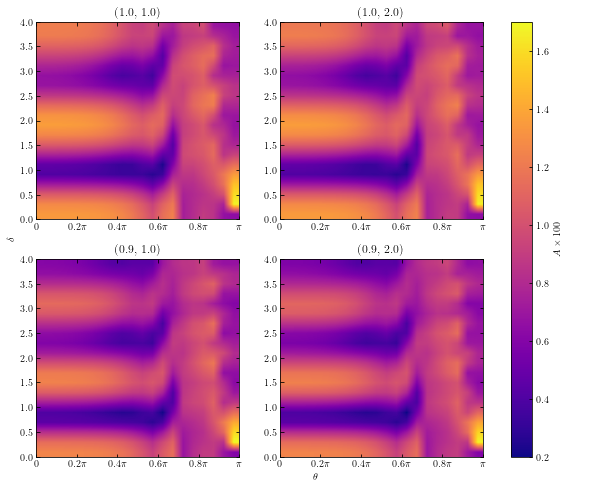

In [235]:
svy = galsurvey.survey(cosmo, ps, survey_geo, survey_params, ingredients, priors)
apriors = [1., 0.9]
bpriors = [1., 2.]
fig, axs = plt.subplots(2, 2, figsize=(10,8))
ax0 = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\delta$')

vmax = 1.7
vmin = 0.2
for i in range(2):
    for j in range(2):
        svy.alpha_prior['mean'] = apriors[i]
        svy.beta_prior['mean'] = bpriors[j]
        Amat = get_Amat(svy)
        ax = axs[i, j]
        cmap = plt.get_cmap('plasma')
        extent = 0, np.pi, 0, 4
        im = ax.imshow(Amat.T*100*(0.2-0.01), cmap=cmap, interpolation='bilinear', 
                       extent=extent, origin='lower', aspect='auto', vmax=vmax, vmin=vmin)
        
        ax.xaxis.set_major_formatter(FuncFormatter(
            lambda val, pos: r'\rm 0' if val==0 else r'\rm {:.3g}$\pi$'.format(val/np.pi) 
            if np.abs(val)!=np.pi else r'$-\pi$' if val==-np.pi else r'$\pi$'))
        ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/5))
        ax.title.set_text('(%.1f, %.1f)'%(apriors[i], bpriors[j]))
#divider = make_axes_locatable(ax0)
#cax = divider.append_axes("right", size="5%", pad='-5%')
#cb = plt.colorbar(im, cax=cax)
cb = fig.colorbar(im, ax=axs.ravel().tolist())
cb.set_label(r'$A\times 100$')
plt.savefig('interferometer_priors.pdf', bbox_inches='tight')
plt.show()

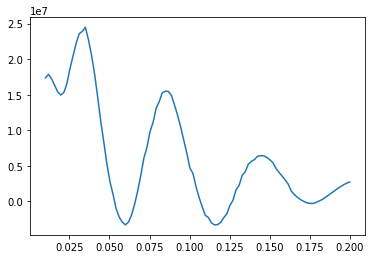

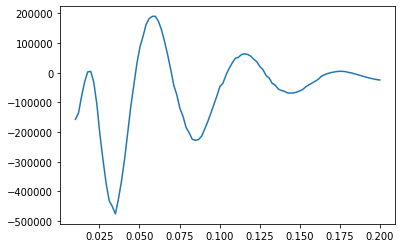

In [111]:
klst = np.linspace(0.01, 0.2, num=100)
rlst=[]
for k in klst:
    rlst.append( desi.bispectrum_derivative(kargs=(k, 0.2, 0.2)))
rlst=np.array(rlst)
plt.plot(klst, rlst[:,0])
plt.show()
plt.plot(klst, rlst[:,1])
plt.show()

In [269]:
svy.zmid_list

array([0.15 , 0.25 , 0.35 , 0.45 , 0.55 , 0.65 , 0.75 , 0.85 , 0.95 ,
       1.05 , 1.15 , 1.25 , 1.35 , 1.45 , 1.55 , 1.65 , 1.75 , 1.85 ,
       1.925])

In [274]:
a=0
a+=np.array([1,2])

In [340]:
a=[(1,2),(3,4)]
b=[0,0]
b=list(zip(b))
[x + y for x, y in zip(a, b)]

[(1, 2, 0), (3, 4, 0)]

In [26]:
import pathos.pools as pp
import numpy as np
p = pp.ProcessPool(4)

In [29]:
list(p.uimap(np.power, [1,9,3], [4,5,6]))

[1, 59049, 729]

In [ ]:
%timeit p.map(np.power, [1,2,3], [4,5,6])

In [ ]:
%timeit p.amap(np.power, [1,2,3], [4,5,6])